In [83]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from umap import UMAP

from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram

from src.dataset.util import read_jsonl, write_jsonl

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
def generate_xticks(df):
    # flag indices, where the next element is different
    yr_switches = np.diff(df["year"])
    # add last element
    yr_switches = np.append(0, yr_switches)
    # convert to bool
    yr_switches = np.array(yr_switches, dtype=bool)

    # get index (x-axis) and year variables (x-axis label)
    sig_index = np.array(df.index)
    sig_year = np.array(df["year"])

    # mark changes in year
    xticks_idx = sig_index[yr_switches]
    xticks_label = sig_year[yr_switches]

    return xticks_idx, xticks_label

# data
select only article bodies with embeddings for further analysis

In [2]:
INTERIM_PATH = '../data/interim/'
PROCESSED_PATH = '../data/processed/'

ds = read_jsonl(os.path.join(PROCESSED_PATH, 'publications_merged_concat.ndjson'))
meta = pd.read_csv(os.path.join(INTERIM_PATH, 'meta_publications_merged.csv'))

In [3]:
df = pd.DataFrame(ds)
df[['id', 'section']] = df['id'].str.split('_', expand=True) 
df.head()

,id,pub_date,text,embeddings,warning,section
0,p1,,Recent studies on mentalizing have shown that ...,"[-0.029172636568546295, 0.004647988826036453, ...",ok :),a
1,p1,,Introduction\nTheory of Mind is defined as the...,"[-0.029943235218524933, -0.007492228876799345,...",ok :),b
2,p2,2013-12-19,Some autistic children pass classic Theory of ...,"[-0.024920951575040817, -0.005315098911523819,...",ok :),a
3,p2,2013-12-19,Introduction\nOne of the most enduring puzzles...,[],"Error code: 400 - {'error': {'message': ""This ...",b
4,p3,,Fast Science is bad for scientists and bad for...,"[-0.015155889093875885, 0.01837518997490406, 0...",ok :),a


In [4]:
meta['year'] = [funk.year for funk in pd.to_datetime(meta['reconstructed_date'], format='mixed')]
meta.head()

,id,title,date,doi,path,source,reconstructed_date,year
0,p1,"Knowing me, knowing you: Spontaneous use of me...",NaN,10.1177/1362361320951017,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2020,2020
1,p2,Autistic adolescents show atypical activation ...,2013-12-19,10.1016/j.neuropsychologia.2013.12.013,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2013-12-19,2013
2,p3,Fast Lane to Slow Science,NaN,10.1016/j.tics.2019.10.007,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2019,2019
3,p4,NaN,NaN,10.1098/rstb.2017.0361,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2018,2018
4,p5,Mapping Mentalising in the Brain,NaN,10.1007/978-3-030-51890-5_2,data/raw/UTA publications/UF papers 2014 - 202...,parsing,2021,2021


In [5]:
df_ = df.merge(meta[['id', 'year', 'source']], on='id', how='left')
df_ = df_.sort_values('year')
df_.head()

,id,pub_date,text,embeddings,warning,section,year,source
318,p161,,,[],empty,a,1969,ocr
319,p161,,\n \n\n \n\nLasy Conf\n\n2»\n\nEMPHASIS AND ME...,"[-0.021632347255945206, 0.029784681275486946, ...",ok :),b,1969,ocr
320,p162,,,[],empty,a,1969,ocr
321,p162,,"\nJ. Oil Pye Pye, Vo. 10, 1963, p15 016, Perga...","[-0.02776145376265049, 0.018291359767317772, -...",ok :),b,1969,ocr
146,p74,,"Normal, autistic, and subnormal children repro...","[-0.03056882508099079, 0.015165209770202637, 0...",ok :),a,1970,parsing


In [6]:
df_.query('warning == "empty"').groupby('section').size()

section
a    155
dtype: int64

In [7]:
df_['warning'] = df_['warning'].str.slice(0, 15)
df_.groupby('warning').size()

warning
Error code: 400     81
empty              155
ok :)              312
dtype: int64

In [8]:
# select only full embeddings & article bodies
df_full_emb = (df_
               .query('warning == "ok :)"')
               .query('section == "b"')
               )

df_full_emb

,id,pub_date,text,embeddings,warning,section,year,source
319,p161,,\n \n\n \n\nLasy Conf\n\n2»\n\nEMPHASIS AND ME...,"[-0.021632347255945206, 0.029784681275486946, ...",ok :),b,1969,ocr
321,p162,,"\nJ. Oil Pye Pye, Vo. 10, 1963, p15 016, Perga...","[-0.02776145376265049, 0.018291359767317772, -...",ok :),b,1969,ocr
149,p75,,\nThe hypothesis of a deficit in central proce...,"[-0.03463025763630867, 0.02869131788611412, 0....",ok :),b,1970,parsing
489,p246,,"\nUW4n Frt6\n\nHeap, Pehl. (197) a2, 618-620\n...","[-0.023243114352226257, 0.017568280920386314, ...",ok :),b,1970,ocr
147,p74,,\nIt has recently been suggested that the unde...,"[-0.030155470594763756, 0.03465669974684715, 0...",ok :),b,1970,parsing
...,...,...,...,...,...,...,...,...
19,p10,2019-06-01,Introduction\nThe Flux congress in Berlin in 2...,"[-0.02512793056666851, 0.015444746240973473, 0...",ok :),b,2019,parsing
11,p6,,"\nGoldman, 2006;\nGopnik, 1993)\n. Autism thu...","[-0.02130638249218464, 0.0030276631005108356, ...",ok :),b,2020,parsing
15,p8,2020-10-01,\nWe are grateful for the careful thought that...,"[-0.02133309282362461, 0.02723802998661995, 0....",ok :),b,2020,parsing
239,p120,,\nwill be revealed and this may well have cons...,"[-0.017162051051855087, 0.013596420176327229, ...",ok :),b,2020,parsing


### source comparison

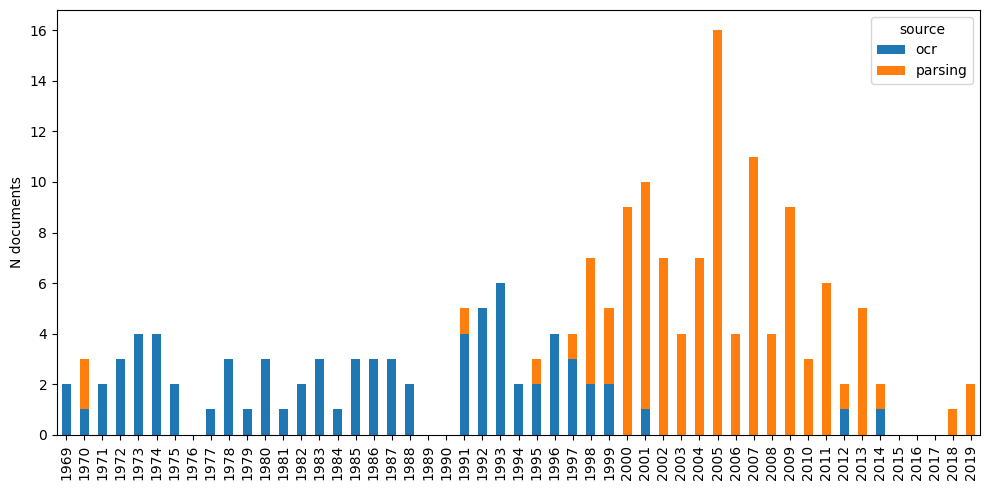

In [44]:
df_full_emb['year_'] = pd.to_datetime(df_full_emb['year'], format='%Y')
all_years = pd.date_range(start=df_full_emb['year_'].min(), end=df_full_emb['year_'].max(), freq='Y').year

proportions = df_full_emb.groupby(['year', 'source']).size().unstack(fill_value=0) #.apply(lambda x: x / x.sum(), axis=1)
proportions = proportions.reindex(all_years, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
proportions.plot(kind='bar', stacked=True, ax=ax)
ax.set_ylabel('N documents')
plt.tight_layout()
plt.savefig('fig/source_breakdown.png', dpi=300)

In [66]:
def get_file_paths(folder_path: str) -> tuple[list, list]:
    """
    """

    pdf_paths = []
    other_paths = []
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            filepath = os.path.join(root, filename)
            if filename.endswith('.pdf'):
                pdf_paths.append(filepath)
            else:
                other_paths.append(filepath)

    return pdf_paths, other_paths

pdf_paths, other_paths = get_file_paths('../data/raw')
pdf_paths = [path[3:] for path in pdf_paths]
len(pdf_paths)

275

In [67]:
# which docs are not overlapping
set(pdf_paths) - set(meta['path'].unique().tolist())

{'data/raw/UTA publications/UF papers 1969-2004 copy/2002/Frith & Happé 2002 ToM & selfconsciousness.pdf',
 'data/raw/UTA publications/UF papers 1969-2004 copy/2003/Snowling03 copy.pdf',
 'data/raw/UTA publications/UF papers 2005-2006 copy/Frith & Happé ASD Primer.pdf',
 'data/raw/UTA publications/UF papers 2005-2006 copy/Happé & Frith 2006.JADD.pdf',
 'data/raw/UTA publications/UF papers 2009-2010 copy/Phil. Trans. R. Soc. B-2009-Happé-1345-50.pdf',
 'data/raw/UTA publications/UF papers 2014 - 2021 copy/Happé&Frith 2020 Autism Concept Changes.pdf',
 'data/raw/UTA publications/UF papers 2014 - 2021 copy/Happé-Frith2021 DimensionalOrCategorical.pdf'}

In [56]:
df_.query('section == "b"').groupby('warning').size()

warning
Error code: 400     81
ok :)              193
dtype: int64

In [82]:
df_.query('section == "b"').groupby('source').size()

source
ocr        120
parsing    154
dtype: int64

We have two types of documents:
- `parsing`: PDFs with extractable text (n=154). Mostly the newer publications that were "born digitally"
- `ocr`: PDFs where we had to conduct optical character recognition ourselves (n=121).

The difference in text quality between these two types of documents is substantial; We address this by using a robust pre-trained model to acquire the representations, but need a couple more checks.  
So far, we successfully parsed 193 PDF files out of 275.  

# 2D plots

In [90]:
X_2d = UMAP(n_components=2, random_state=42, metric='cosine').fit_transform(df_full_emb['embeddings'].tolist())

/Users/au582299/Repositories/friths/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


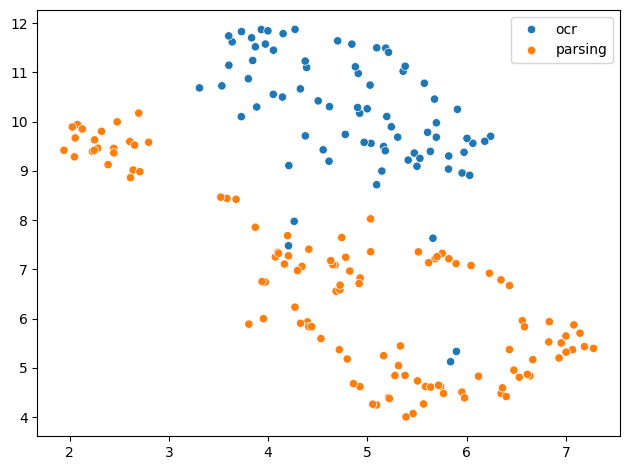

In [92]:
sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=df_full_emb['source'].tolist(),
)

plt.tight_layout()
plt.savefig('fig/embeddings_umap.png', dpi=300)

# infodynamics

In [10]:
X = df_full_emb['embeddings'].tolist()
X = np.array(X)
X.shape

(193, 1536)

In [11]:
X_prob = [calc_vector_histogram(vect, bins=100) for vect in X]
X_prob = np.array(X_prob)
X_prob.shape

(193, 100)

In [16]:
wd = WindowedRollingDistance(
    measure='jensenshannon',
    window_size=5,
    estimate_error=True
)

signal = wd.fit_transform(X_prob)

In [31]:
signal_df = pd.DataFrame(signal)
signal_df['id'] = df_full_emb['id'].tolist()
signal_df['year'] = df_full_emb['year'].tolist()
signal_df['source'] = df_full_emb['source'].tolist()
signal_df.head()

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,id,year,source
0,0.0,0.0,0.234154,0.038032,-0.234154,0.019016,p161,1969,ocr
1,0.0,0.0,0.093529,0.026838,-0.093529,0.013419,p162,1969,ocr
2,0.0,0.0,0.081908,0.016213,-0.081908,0.008106,p75,1970,parsing
3,0.0,0.0,0.130393,0.039064,-0.130393,0.019532,p246,1970,ocr
4,0.0,0.0,0.140680,0.091650,-0.140680,0.045825,p74,1970,parsing


## novelty signal

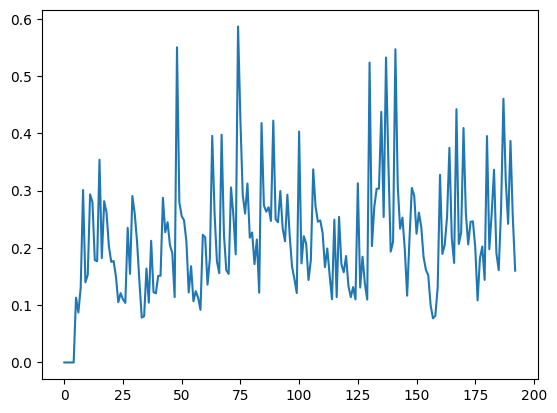

In [17]:
plt.plot(signal['N_hat'])

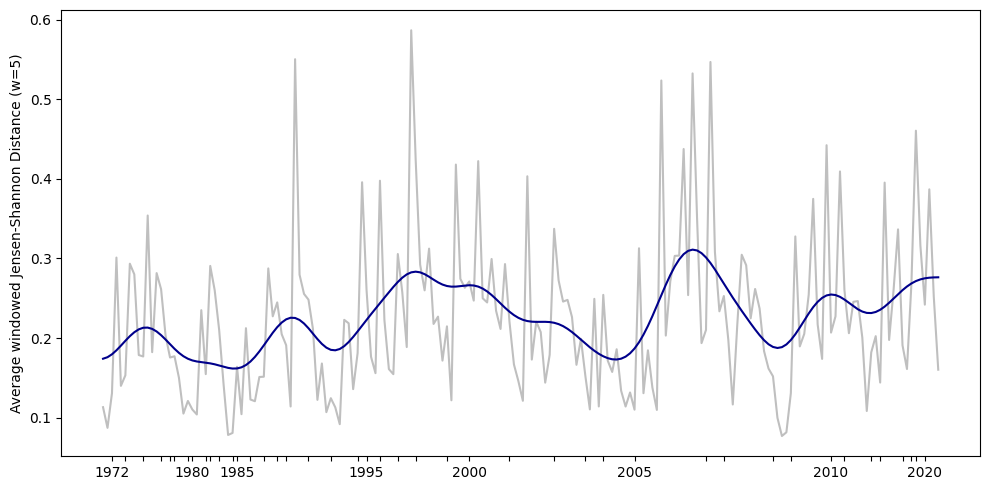

In [94]:
n_df = signal_df.iloc[5:, :]
n_hat = n_df['N_hat'].tolist()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(n_hat, c='grey', alpha=0.5)
ax.plot(
    gaussian_filter1d(n_hat, sigma=5), c='darkblue'
)

xticks_idx_n, xticks_label_n = generate_xticks(n_df.reset_index())
modified_ticks = ['' if i % 5 != 0 and i != xticks_label_n[0] else i for i in xticks_label_n]

values_to_hide = [1975]
modified_ticks = ['' if i in values_to_hide else i for i in modified_ticks]

ax.set_xticks(ticks=xticks_idx_n, labels=modified_ticks)
ax.set_ylabel('Average windowed Jensen-Shannon Distance (w=5)')

plt.tight_layout()
plt.savefig('fig/novelty_w5.png', dpi=300)

### peaks

In [34]:
n_df.query('N_hat > 0.5')

,N_hat,N_sd,T_hat,T_sd,R_hat,R_sd,id,year,source
48,0.550319,0.057192,0.377698,0.077071,0.172620,0.067131,p207,1991,ocr
74,0.586651,0.092154,0.322148,0.144459,0.264503,0.118307,p222,1997,ocr
130,0.523575,0.059740,0.304814,0.213727,0.218761,0.136733,p135,2005,parsing
137,0.532483,0.222631,0.339537,0.190343,0.192945,0.206487,p126,2005,parsing
141,0.546851,0.075195,0.363532,0.096249,0.183320,0.085722,p121,2006,parsing


In [42]:
peak_ids = n_df.query('N_hat > 0.5')['id'].tolist()

meta.query('id == @peak_ids').sort_values('year')['path'].tolist()

['data/raw/UTA publications/UF papers 1969-2004 copy/1991/Frith, The cognitive explanation of autism.pdf',
 'data/raw/UTA publications/UF papers 1969-2004 copy/1997/Frith and Frith, The brain basis of belief.pdf',
 'data/raw/UTA publications/UF papers 2005-2006 copy/Primer ASD FrithHappe 05.pdf',
 'data/raw/UTA publications/UF papers 2005-2006 copy/Silani Dys Proofs.pdf',
 'data/raw/UTA publications/UF papers 2005-2006 copy/2006WhiteEtAlDysAut.pdf']

- 1991 peak: The cognitive explanation of autism (MRC News)
- 1997 peak: The Brain Basis of Belief (MRC Cognitive Development Unit, Information Bulletin)
- 2005 peak 1: Autism spectrum disorder (Primer in Current Biology)
- 2005 peak 2: Brain abnormalities underlying altered activation in dyslexia: a voxel based morphometry study (in Brain)
- 2006 peak: A double dissociation between sensorimotor impairments and reading disability: A comparison of autistic and dyslexic children (in Cognitive Neuropsychology)

In [47]:
meta.query('id == "p44"')['path'].tolist()

['data/raw/UTA publications/UF papers 1969-2004 copy/2001/Paulesu, Demonet, Fazio et al., Dyslexia - Cultural diversity and biological unity.pdf']